## BalanceNet prototype

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
dir = '/content/drive/MyDrive/projects/text-emotion-classification-master/'

In [3]:
%run /content/drive/MyDrive/projects/text-emotion-classification-master/Setup.ipynb
%run /content/drive/MyDrive/projects/text-emotion-classification-master/ExtraFunctions.ipynb

[i] Loaded Parameters:
 40000 35 0.2 200 
 /content/drive/MyDrive/projects/text-emotion-classification-master/dataset/glove/glove.twitter.27B.200d.txt
[i] Importing Modules...
[+] Using Keras version 2.12.0
[+] Finished Importing Modules
[i] Reading from csv file...Done!
[i] Found 34359 unique tokens.
[+] Shape of data tensor: (47288, 30)
[+] Shape of label tensor: (47288, 5)
[i] Number of entries in each category:
[+] Training:
 [ 7714. 12989. 12778.  3456.   894.]
[+] Validation:
 [1929. 3308. 3160.  845.  215.]
[i] Loading GloVe from: /content/drive/MyDrive/projects/text-emotion-classification-master/dataset/glove/glove.twitter.27B.200d.txt ...Done.
[+] Proceeding with Embedding Matrix...[i] Completed!
[i] Finished running setup.


In [4]:
x_train[0]

array([    0,     0,     0,     0,     0,     0,     0,     0, 11035,
         577,  1259,  6998,  1349,    26,   213, 11036,  2978,  2772,
         362,   528,   305,  8782,  5490,     2, 12842,     0,     0,
           0,     0,     0], dtype=int32)

In [5]:
# second embedding matrix for non-static channel
embedding_matrix_ns = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_ns[i] = embedding_vector
print("Completed!")

Completed!


In [6]:
x_train[0]

array([    0,     0,     0,     0,     0,     0,     0,     0, 11035,
         577,  1259,  6998,  1349,    26,   213, 11036,  2978,  2772,
         362,   528,   305,  8782,  5490,     2, 12842,     0,     0,
           0,     0,     0], dtype=int32)

In [7]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
import tensorflow  as tf
# static channel

embedding_layer_frozen = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
embedded_sequences_frozen = embedding_layer_frozen(sequence_input)

# non-static channel
embedding_layer_train = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix_ns],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences_train = embedding_layer_train(sequence_input)

First Half: LSTM > CNN

In [8]:

l_lstm1f = Bidirectional(LSTM(6,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(embedded_sequences_frozen)
l_lstm1t = Bidirectional(LSTM(6,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(embedded_sequences_train)
l_lstm1 = Concatenate(axis=1)([l_lstm1f, l_lstm1t])

In [9]:

l_conv_2 = Conv1D(filters=24,kernel_size=2,activation='relu')(l_lstm1)
l_conv_2 = Dropout(0.3)(l_conv_2)
l_conv_3 = Conv1D(filters=24,kernel_size=3,activation='relu')(l_lstm1)
l_conv_3 = Dropout(0.3)(l_conv_3)

l_conv_5 = Conv1D(filters=24,kernel_size=5,activation='relu',)(l_lstm1)
l_conv_5 = Dropout(0.3)(l_conv_5)
l_conv_6 = Conv1D(filters=24,kernel_size=6,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(l_lstm1)
l_conv_6 = Dropout(0.3)(l_conv_6)

l_conv_8 = Conv1D(filters=24,kernel_size=8,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(l_lstm1)
l_conv_8 = Dropout(0.3)(l_conv_8)

conv_1 = [l_conv_6,l_conv_5, l_conv_8,l_conv_2,l_conv_3]

l_lstm_c = Concatenate(axis=1)(conv_1)

Second Half: CNN > LSTM

In [10]:
l_conv_4f = Conv1D(filters=12,kernel_size=4,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(embedded_sequences_frozen)
l_conv_4f = Dropout(0.3)(l_conv_4f)
l_conv_4t = Conv1D(filters=12,kernel_size=4,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(embedded_sequences_train)
l_conv_4t = Dropout(0.3)(l_conv_4t)

l_conv_3f = Conv1D(filters=12,kernel_size=3,activation='relu',)(embedded_sequences_frozen)
l_conv_3f = Dropout(0.3)(l_conv_3f)
l_conv_3t = Conv1D(filters=12,kernel_size=3,activation='relu',)(embedded_sequences_train)
l_conv_3t = Dropout(0.3)(l_conv_3t)

l_conv_2f = Conv1D(filters=12,kernel_size=2,activation='relu')(embedded_sequences_frozen)
l_conv_2f = Dropout(0.3)(l_conv_2f)
l_conv_2t = Conv1D(filters=12,kernel_size=2,activation='relu')(embedded_sequences_train)
l_conv_2t = Dropout(0.3)(l_conv_2t)

conv_2 = [l_conv_4f, l_conv_4t,l_conv_3f, l_conv_3t, l_conv_2f, l_conv_2t]

l_merge_2 = Concatenate(axis=1)(conv_2)
l_c_lstm = Bidirectional(LSTM(12,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(l_merge_2)

Combine both halfs of the model

In [11]:
l_merge = Concatenate(axis=1)([l_lstm_c, l_c_lstm])
l_pool = MaxPooling1D(4)(l_merge)
l_drop = Dropout(0.5)(l_pool)
l_flat = Flatten()(l_drop)
l_dense = Dense(26, activation='relu')(l_flat)
preds = Dense(5, activation='softmax')(l_dense)

In [12]:
# from tensorflow.keras import multi_gpu_model
model = Model(sequence_input, preds)
adadelta = optimizers.Adadelta()
lr_metric = get_lr_metric(adadelta)
# model = multi_gpu_model(model, gpus = 2, cpu_merge = True, cpu_relocation = False)
model.compile(loss='categorical_crossentropy',
              optimizer=adadelta,
              metrics=['acc'])

In [13]:
!rm -r logs

rm: cannot remove 'logs': No such file or directory


In [14]:
tensorboard = callbacks.TensorBoard(log_dir='./logs', histogram_freq=0,  write_graph=True)
model_checkpoints = callbacks.ModelCheckpoint("checkpoint-{val_loss:.3f}.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
lr_schedule = callbacks.LearningRateScheduler(initial_boost)

In [15]:
model.summary()
model.save('BalanceNet.h5')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 200)      6872000     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 30, 200)      6872000     ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 30, 12)       9936        ['embedding[0][0]']              
                                                                                              

In [16]:
model = keras.models.load_model(dir+"checkpoint-0.905.h5")

Time to train!!

In [14]:
x_train[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,  1902,     4,  3734, 10743,     0,     0,
           0,     0,     0], dtype=int32)

In [15]:
print("Training Progress:")
model_log = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=200, batch_size=128,
          callbacks=[tensorboard, model_checkpoints])
pandas.DataFrame(model_log.history).to_csv("history-balance.csv")

In [17]:


from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format = 'retina'
import itertools, pickle

with open(dir+'tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

classes = ["neutral", "happy", "sad", "hate","anger"]



In [18]:
# model_test = load_model(dir+'checkpoint-0.905.h5')
model_test = load_model('best_weights.h5')
Y_test = np.argmax(y_val, axis=1) # Convert one-hot to index
y_pred = model_test.predict(x_val)
y_pred_class = np.argmax(y_pred,axis=1)
cnf_matrix = confusion_matrix(Y_test, y_pred_class)

296/296 [==============================] - 18s 53ms/step


In [18]:
print(classification_report(Y_test, y_pred_class, target_names=classes))

              precision    recall  f1-score   support

     neutral       0.51      0.44      0.47      1939
       happy       0.67      0.73      0.70      3205
         sad       0.65      0.69      0.67      3229
        hate       0.85      0.64      0.73       870
       anger       0.87      0.74      0.80       214

    accuracy                           0.65      9457
   macro avg       0.71      0.65      0.68      9457
weighted avg       0.65      0.65      0.65      9457



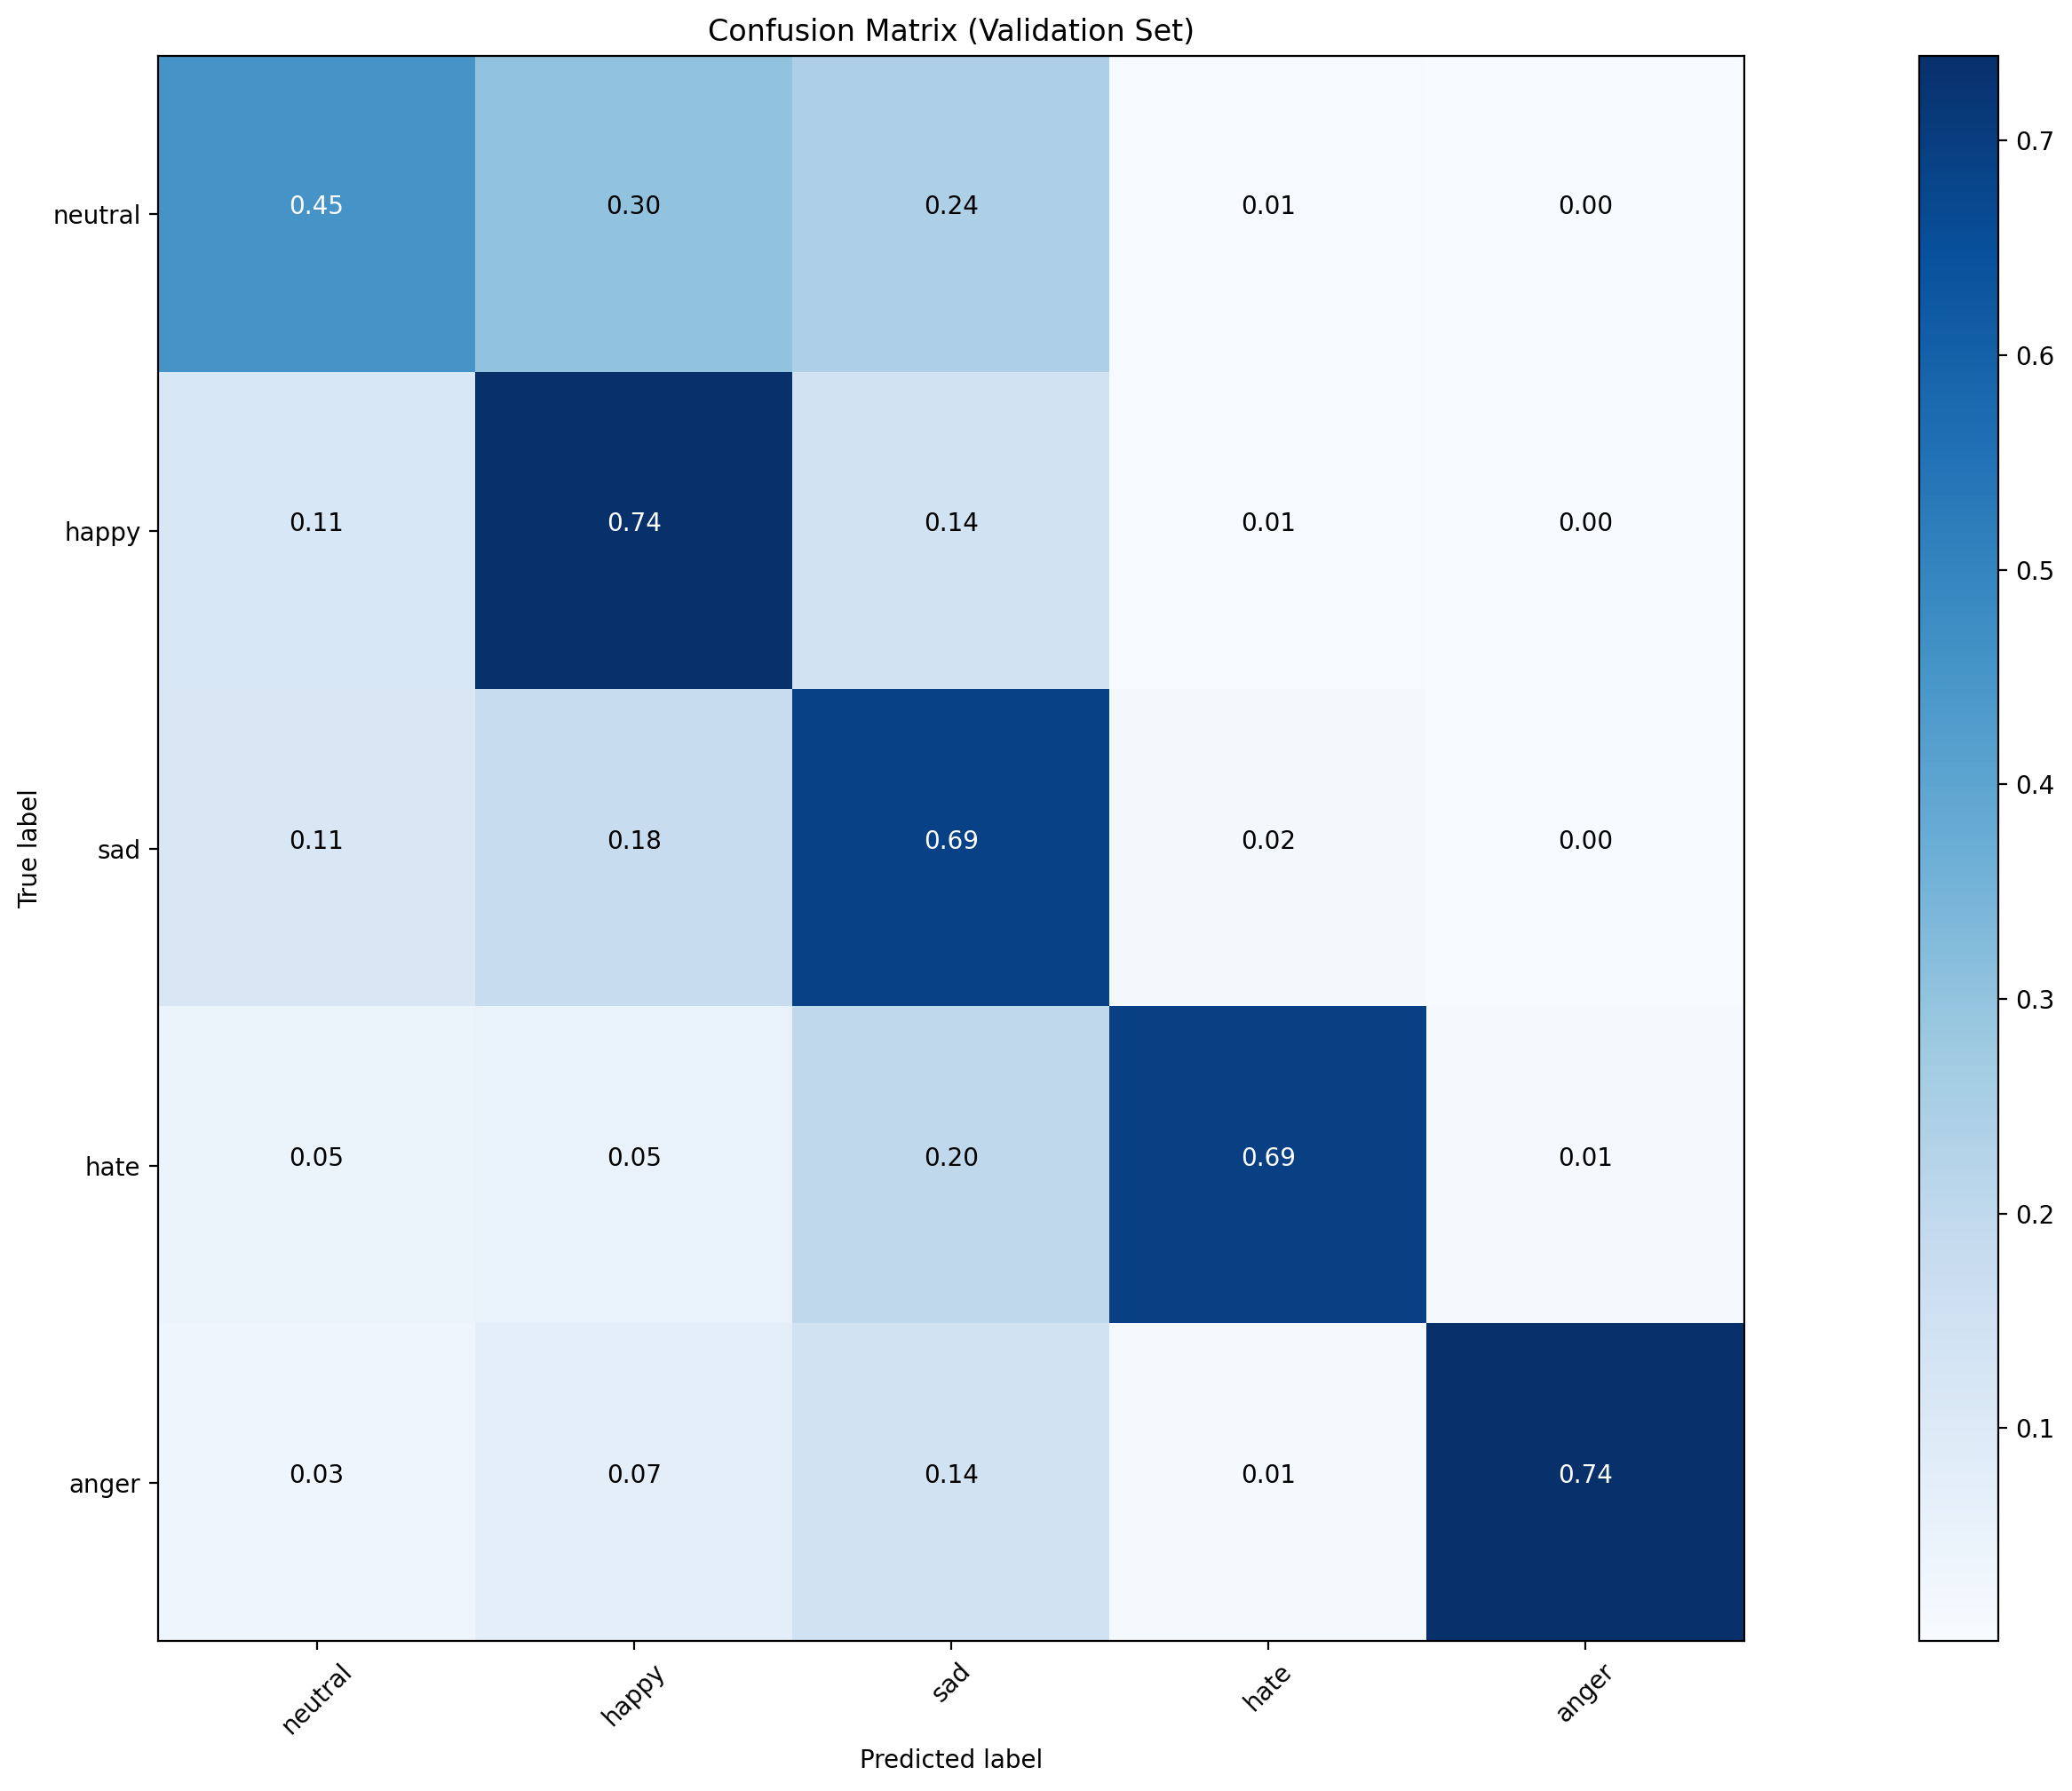

In [40]:
def plot_confusion_matrix(cm, labels,
                          normalize=True,
                          title='Confusion Matrix (Validation Set)',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, labels=classes)

In [19]:
text = ["I salute you for the bravery and sacrifice! A true hero indeed.",
        "I am sorry but I trust HRW I damned sight more than the PAP and it's cronies! Off course the PAP will say that they (HRW) made things up...despite of the fact that SG is a dictator state!?",
        "PAP are taking the piss again!",
        "Thought he sold his kidney to buy it; Instead, he bought a kidney then bought the car Filthy rich This is why we need communism",
        "Somebody needs to water Tharman's head, hair needs to be grown there",
        "what a nuisance fk. a proper clean and flat footpath,,now obstructed by sharedbikes..! which idiotic MP allowed this to happen?",
        "What baby bonus scheme ??? To grow up a kid in Singapore you think is easy now bo ??? Both parent need to work to grow up a kid until 21 , you think tats easy bo ??? Think la"
       ]

In [20]:
sequences_test = tokenizer.texts_to_sequences(list(map(lambda x:x.split(),text)))
data_int_t = pad_sequences(sequences_test, padding='pre', maxlen=(MAX_SEQUENCE_LENGTH-5))
data_test = pad_sequences(data_int_t, padding='post', maxlen=(MAX_SEQUENCE_LENGTH))
y_prob = model.predict(data_test)
for n, prediction in enumerate(y_prob):
    pred = y_prob.argmax(axis=-1)[n]
    print(text[n],"\nPrediction:",classes[pred],"\n")

1/1 [==============================] - 3s 3s/step
I salute you for the bravery and sacrifice! A true hero indeed. 
Prediction: happy 

I am sorry but I trust HRW I damned sight more than the PAP and it's cronies! Off course the PAP will say that they (HRW) made things up...despite of the fact that SG is a dictator state!? 
Prediction: sad 

PAP are taking the piss again! 
Prediction: neutral 

Thought he sold his kidney to buy it; Instead, he bought a kidney then bought the car Filthy rich This is why we need communism 
Prediction: sad 

Somebody needs to water Tharman's head, hair needs to be grown there 
Prediction: neutral 

what a nuisance fk. a proper clean and flat footpath,,now obstructed by sharedbikes..! which idiotic MP allowed this to happen? 
Prediction: neutral 

What baby bonus scheme ??? To grow up a kid in Singapore you think is easy now bo ??? Both parent need to work to grow up a kid until 21 , you think tats easy bo ??? Think la 
Prediction: sad 



##On original story and generated story for the final evaluation

In [22]:
sgs = pd.read_csv(dir+'test_predicted_story.csv')

In [23]:
sgs.columns

Index(['storytitle', 'storyline', 'story', 'titleLineConcat',
       'predicted_storylines', 'predicted_titleLineConcat', 'predicted_story'],
      dtype='object')

In [30]:
story = sgs['story'].values
generated_story = sgs['predicted_story'].values
title = sgs['storytitle'].values
story_line = sgs['storyline'].values
generated_story_line = sgs['predicted_storylines'].values

In [25]:
sequences_test = tokenizer.texts_to_sequences(list(map(lambda x:x.split(),story)))
data_int_t = pad_sequences(sequences_test, padding='pre', maxlen=(MAX_SEQUENCE_LENGTH-5))
data_test = pad_sequences(data_int_t, padding='post', maxlen=(MAX_SEQUENCE_LENGTH))
y_prob_title = model.predict(data_test)

1/1 [==============================] - 0s 80ms/step


In [26]:
sequences_test = tokenizer.texts_to_sequences(list(map(lambda x:x.split(),generated_story)))
data_int_t = pad_sequences(sequences_test, padding='pre', maxlen=(MAX_SEQUENCE_LENGTH-5))
data_test = pad_sequences(data_int_t, padding='post', maxlen=(MAX_SEQUENCE_LENGTH))
y_prob_story = model.predict(data_test)

1/1 [==============================] - 0s 71ms/step


In [38]:
count = 0
for n,(_,_) in enumerate(zip(y_prob_title,y_prob_story)):
    pred_title = y_prob_title.argmax(axis=-1)[n]
    pred_story = y_prob_story.argmax(axis=-1)[n]
    print('\nSample:',n+1,'\nTitle: ',title[n],'\nOriginal Story:\n',story[n],'\nEmotion: ',classes[pred_title],'\n\n','Generated Story: \n',generated_story[n],'\nEmotion: ',classes[pred_story])
    if classes[pred_title] == classes[pred_story]:
      count+=1



Sample: 1 
Title:  Drunk Dialing 
Original Story:
 Tom had problems with depression.He decided to drink one night.He went overboard and started calling people.He called some exes.It create a lot of problems in his life. 
Emotion:  sad 

 Generated Story: 
 The man hung up the phone.The woman continued to have a conversation.The man was drunk.The women confronted the man.They apologized. 
Emotion:  sad

Sample: 2 
Title:  Scrambled Eggs 
Original Story:
 Aya woke early one morning to surprise her husband with a hot meal.He began work at 6AM, so usually she was only awake to say goodbye.But this morning, she made him a big hot dish of scrambled eggs.Then she woke him and smiled as he dove in - until he grimaced.Aya had missed a large chunk of eggshell, and it had cut her husband! 
Emotion:  sad 

 Generated Story: 
 The man made some eggs.He scrambled the eggs.The eggs were scrambled.The man scrambled them again.He made more eggs. 
Emotion:  happy

Sample: 3 
Title:  Trick or Treating 


###Final accuracy of comparing the emotions portrayed by the generation algorithm

In [39]:
print(f'Accuracy: {count/sgs.shape[0]*100}%')

Accuracy: 45.16129032258064%
